# **Visualization Project- PreProcess**

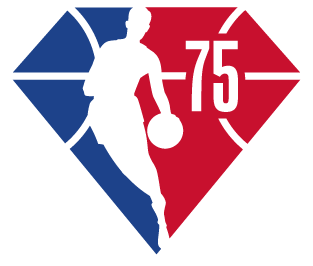

In [ ]:
!pip install nba_api

# **packages**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from time import sleep
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.static.players import find_players_by_full_name

## **Find 100 Location where the most shots were thrown.** 

In [ ]:
def find_100_most_frequent_locations_throws(data_frame):
    
    specific_location_X_Y=[]
    counter_throws=[]
    on_court_X=[]
    on_court_Y=[]
    counter_of_throws_in_each_location= {}

    for i in range(len(data_frame)):
        row = data_frame.iloc[i]

        if row.LOC_X+250 != 0:
           location_X_normalized=int(((row.LOC_X+250) /485) * 30)
        else:
            location_X_normalized=0
        if row.LOC_Y+50 != 0:
           location_Y_normalized=int(((row.LOC_Y+50) / 300) * 20)
        else:
            location_Y_normalized=0

        x_loc_on_court = ((location_X_normalized * 485) / 30 + ((location_X_normalized + 1) * 485) / 30) / 2 - 250 
        y_loc_on_court = ((location_Y_normalized * 300) / 20 + ((location_Y_normalized + 1) * 300) / 20) / 2 - 50  

        on_court_X.append(x_loc_on_court)
        on_court_Y.append(y_loc_on_court)

        if (x_loc_on_court,y_loc_on_court) not in counter_of_throws_in_each_location:
          counter_of_throws_in_each_location[(x_loc_on_court,y_loc_on_court)] = 1
        else:
          counter_of_throws_in_each_location[(x_loc_on_court,y_loc_on_court)] += 1
        
    for j in range(len(data_frame)):        
        counter_throws.append(counter_of_throws_in_each_location[(on_court_X[j],on_court_Y[j])] )

    
    data_frame['COUNT_THROWS_LOC'] = counter_throws
    data_frame['ON_COURT_LOC_X'] = on_court_X
    data_frame['ON_COURT_LOC_Y'] = on_court_Y
  
    data_frame2=data_frame.copy()
    #sorting the best 100 locations
    data_frame2=data_frame2.drop_duplicates(subset=['ON_COURT_LOC_X', 'ON_COURT_LOC_Y'], keep='first').sort_values(by='COUNT_THROWS_LOC', ascending=False)[:100]
    
    dict_locX_locY_amount_shots = dict([((x,y),z) for x,y,z in zip(data_frame2.ON_COURT_LOC_X, data_frame2.ON_COURT_LOC_Y,data_frame2.COUNT_THROWS_LOC)])

    dict_best_player={}
    made_shots_in_each_location={}
    
    for i in range(len(data_frame)):
        row = data_frame.iloc[i]
        key=(row.ON_COURT_LOC_X,row.ON_COURT_LOC_Y)
        
        if key in list(dict_locX_locY_amount_shots.keys()):

          if key not in made_shots_in_each_location:
             made_shots_in_each_location[key]=0

          if row.SHOT_MADE_FLAG==1:    
                made_shots_in_each_location[key]+=1
          
          if key not in dict_best_player:
            dict_best_player[key]={row.PLAYER_NAME:[0,0]}
          
          if row.PLAYER_NAME not in dict_best_player[key]:
            dict_best_player[key].update({row.PLAYER_NAME:[0,0]})

          if row.PLAYER_NAME in dict_best_player[key]:
                if row.SHOT_MADE_FLAG==1:    
                   dict_best_player[key][row.PLAYER_NAME][0]+=1
                dict_best_player[key][row.PLAYER_NAME][1]+=1

    percentage_in_each_location=[made_shots_in_each_location[x]/dict_locX_locY_amount_shots[x] for x in dict_locX_locY_amount_shots]
    
    dict_percent_player={}
    lst_most_shots_player=[]
    lst_amount_shots=[]
    lst_field_goal=[]
    for i in range(len(data_frame2)):
        row = data_frame2.iloc[i]
        key=(row.ON_COURT_LOC_X,row.ON_COURT_LOC_Y)
        lst_items_player_percentage=list(dict_best_player[key].items())
        lst_items_player_percentage=sorted(lst_items_player_percentage,key=lambda x: x[1][1],reverse=True)
        dict_percent_player[key]=lst_items_player_percentage[0]
        lst_most_shots_player.append(lst_items_player_percentage[0][0])
        lst_amount_shots.append(lst_items_player_percentage[0][1][1])
        fg=lst_items_player_percentage[0][1][0]/lst_items_player_percentage[0][1][1]
        lst_field_goal.append(fg)


    data_frame2['FG_LOCATION'] = percentage_in_each_location
    data_frame2['PLAYER_MOST_FREQUENCY_LOC'] = lst_most_shots_player
    data_frame2['FG_OF_PLAYER_MOST_FREQUENCY_LOC'] = lst_field_goal
    data_frame2['AMOUNT_THROWS_OF_PLAYER_MOST_FREQUENCY_LOC'] = lst_amount_shots

    return data_frame2

### **Running On Each Season between 2000-2020 and taking those 100 location and their details**

In [ ]:
season=['2000-01','2001-02','2002-03','2003-04','2004-05','2005-06','2006-07','2007-08','2008-09','2009-10','2010-11','2011-12','2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21']

In [ ]:
df=[]

In [ ]:
for s in season:
    shotchart_detail = ShotChartDetail(team_id=0, player_id=0, context_measure_simple='FGA', season_nullable=s, timeout=90)
    shot_df = shotchart_detail.get_data_frames()[0]
    best_100 = find_100_most_frequent_locations_throws(data_frame=shot_df)
    df.append(best_100)
    sleep(1)

### **I download the file (100 location in each 21 seasons)**

In [ ]:
pd.concat(df).to_csv('21Seasons_Locations_top100_new.csv')

### **Reading It**

In [ ]:
x=pd.read_csv('21Seasons_Locations_top100_new.csv')

### **Putting The Season as a Column in DataFrame**

In [ ]:
lst=[]
for i in x.GAME_DATE:
  year_string=str(i)
  year_string=year_string[0:4]
  int_year=int(year_string)
  lst.append(int_year)
x['season']=lst

### **Calculating the relation between the amount of 3 point shots to all shots**

In [ ]:
y=x[['FG_LOCATION','SHOT_ZONE_BASIC']]
lst_shot_zone_basic_new=[]
lst=[]
lst_mid=[]
lst_restrict=[]
lst_paint=[]
for j in range(21):
  new_df=x[100*j:(j+1)*100]
  c_3points=0
  c_2points=0
  C2_MID=0
  C2_RESTRICT=0
  C2_PAINT=0
  for i in range(len(new_df)):
    row=new_df.iloc[i]
    if '3' in row.SHOT_ZONE_BASIC:
      c_3points+=row.COUNT_THROWS_LOC
      lst_shot_zone_basic_new.append('Above The break 3')
    else:
      c_2points+=row.COUNT_THROWS_LOC
      if row.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)':
        lst_shot_zone_basic_new.append('In The Paint (Non-RA)')
        C2_PAINT+=row.COUNT_THROWS_LOC
      if row.SHOT_ZONE_BASIC == 'Restricted Area':
        lst_shot_zone_basic_new.append('Restricted Area')
        C2_RESTRICT+=row.COUNT_THROWS_LOC
      if row.SHOT_ZONE_BASIC == 'Mid-Range':
          lst_shot_zone_basic_new.append('Mid-Range')
          C2_MID+=row.COUNT_THROWS_LOC
  
  lst.append((c_3points/(c_3points+c_2points)))
  lst_mid.append((C2_MID/(c_3points+c_2points)))
  lst_restrict.append((C2_RESTRICT/(c_3points+c_2points)))
  lst_paint.append((C2_PAINT/(c_3points+c_2points)))

x['SHOT_ZONE_BASIC']=lst_shot_zone_basic_new


In [ ]:
df_relation_3shots_allshots=pd.DataFrame()
year1=1999
lst_year1=[]
lst_year2=[]
lst_relation3=[]
lst_relation_mid=[]
lst_relation_paint=[]
lst_relation_restrict=[]

for i in range(1,len(lst)+1):
  year_location=lst[0:i]
  year_paint=lst_paint[0:i]
  year_restrict=lst_restrict[0:i]
  year_mid=lst_mid[0:i]
  year1+=1
  year2=1999
  for j in range(len(year_location)):
    year2+=1
    lst_year1.append(year1)
    lst_year2.append(year2)
    lst_relation3.append(year_location[j])
    lst_relation_mid.append(year_mid[j])
    lst_relation_paint.append(year_paint[j])
    lst_relation_restrict.append(year_restrict[j])

df_relation_3shots_allshots['season']=lst_year1
df_relation_3shots_allshots['year'] = lst_year2
df_relation_3shots_allshots['3Points_Shots_To_All_Shots'] = lst_relation3
df_relation_3shots_allshots['MID_Points_Shots_To_All_Shots'] = lst_relation_mid
df_relation_3shots_allshots['PAINT_Points_Shots_To_All_Shots'] = lst_relation_paint
df_relation_3shots_allshots['RESTRICT_Points_Shots_To_All_Shots'] = lst_relation_restrict


### **Download The File**

In [ ]:
df_relation_3shots_allshots.to_csv('each_area_relation.csv')

הבהרה חשובה מאוד !!
מכיוון שאני הורדתי את הקבצים אליי למחשב, אם תרצו להריץ- ההרצה לוקחת כשעה מכיוון שזה 4 מיליון נתונים מ 21 עונות. 
בנוסף לכך יש בעיה כללית לגבי החבילה (לאחר בירור באינטרנט גיליתי שזה באג ב חבילה)
ב nba_api
יש באג כאשר מבקשים נתונים של עונה מסוימת - פשוט יש צורך להריץ עוד פעם עד שהשגיאה מפסיקה וזה מתחיל לרוץ.
לכן זה לוקח כקצת יותר משעה הרצה.

מכיוון שאני מעלה את הקבצים איתי להגשה, תוכלו לראות את מה שפירטתי בדו"ח כיצד זה בא לידי ביטוי בקבצים עצמם.

* זה מיועד אך ורק אם תרצו להריץ קובץ זה *